In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import os
import re

In [11]:
data_dir = "/data/cb/asapp/VAST/sim_results/buoy/"  

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

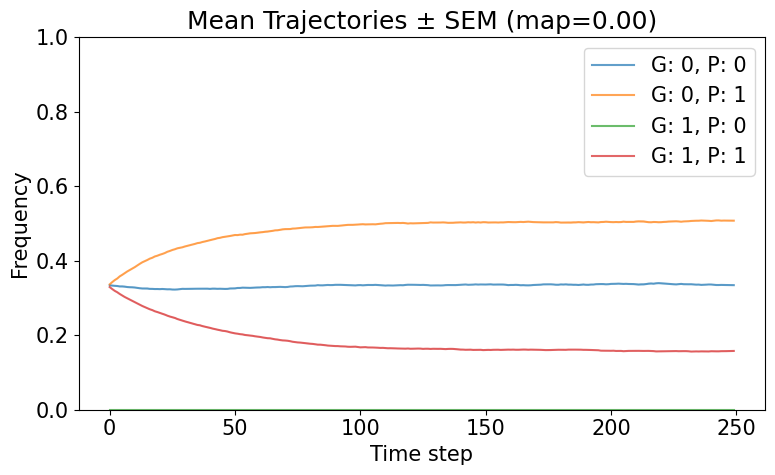

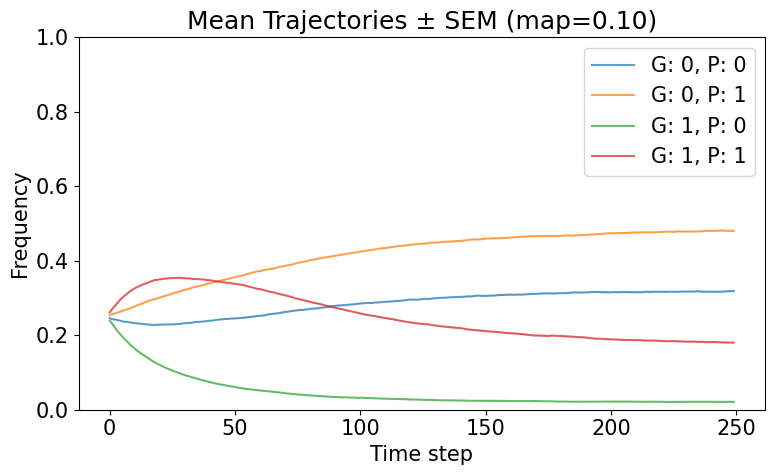

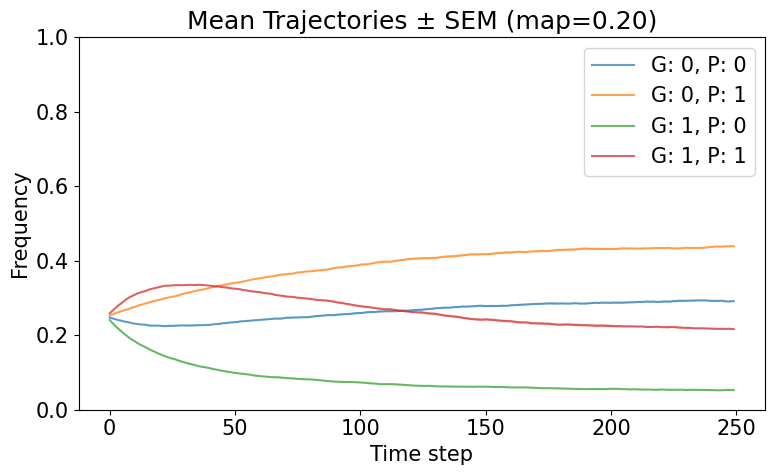

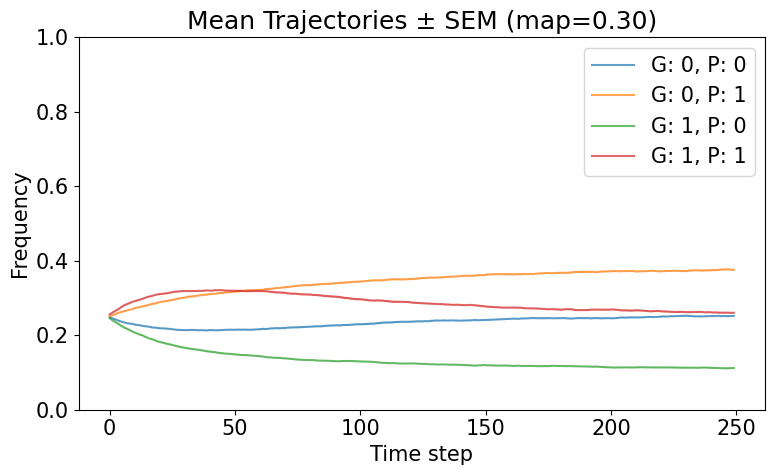

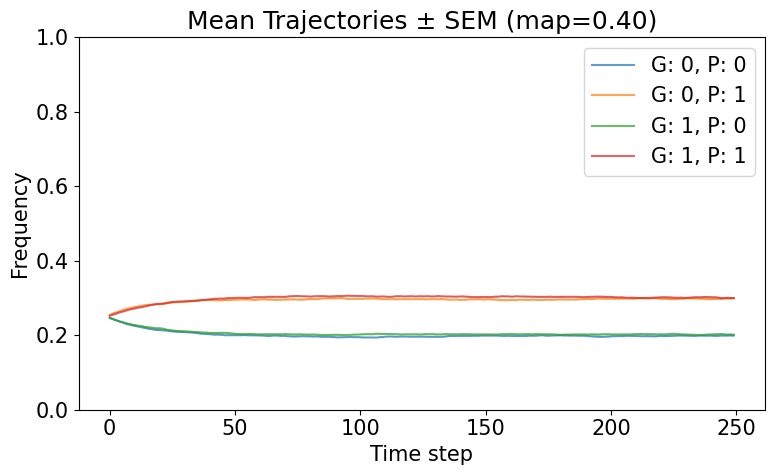

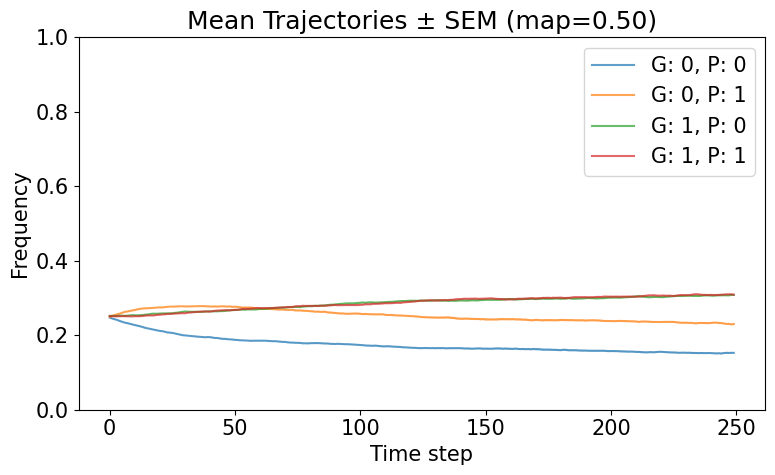

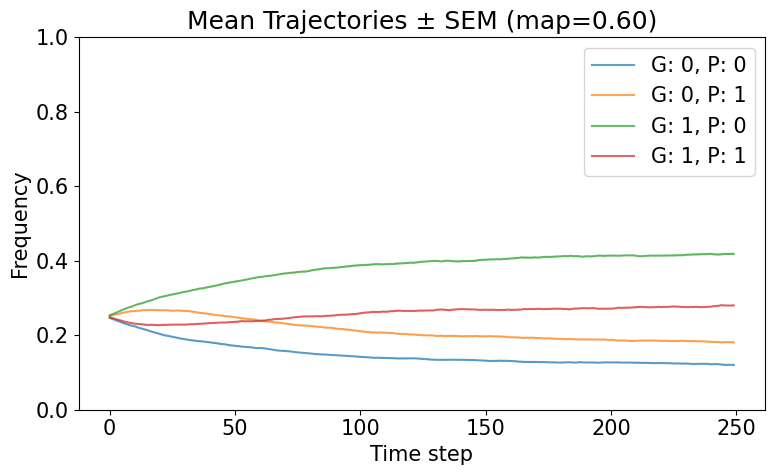

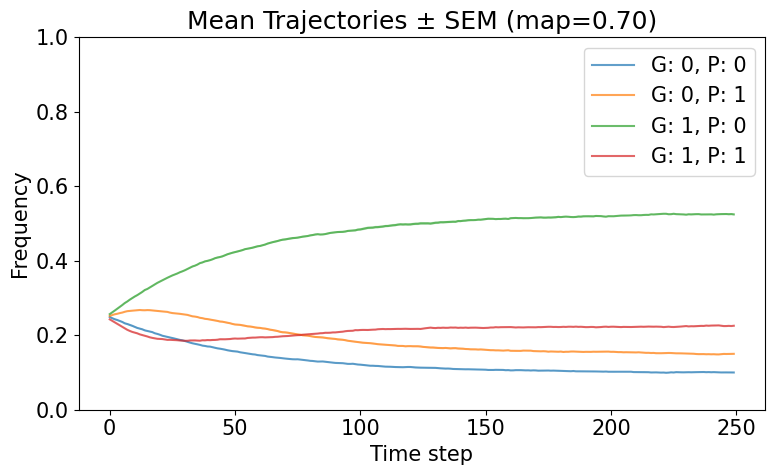

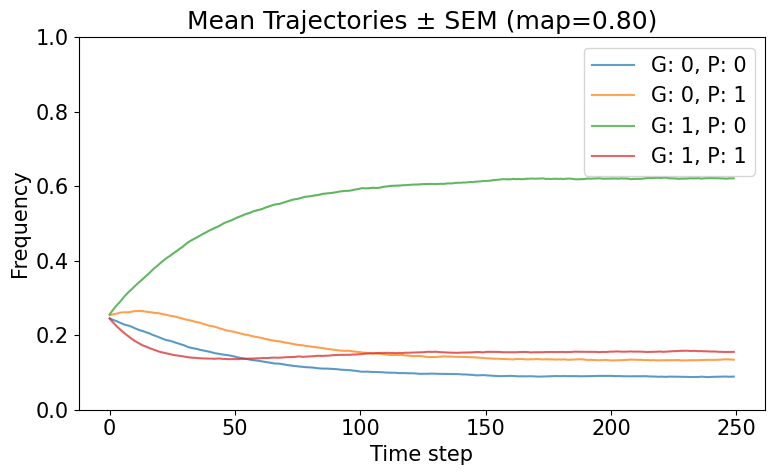

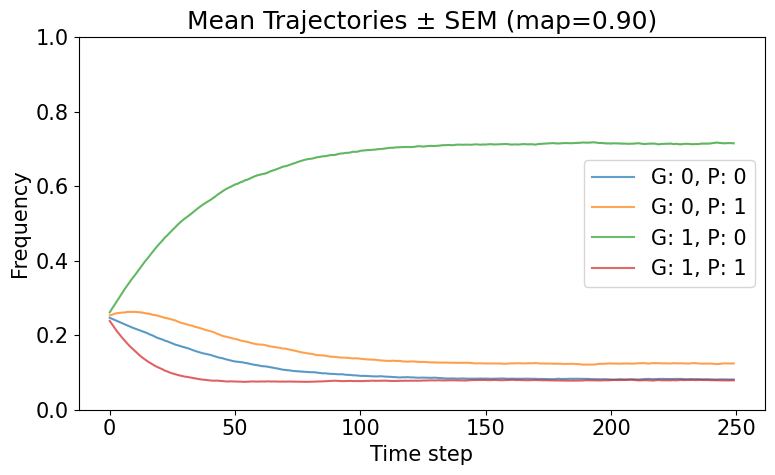

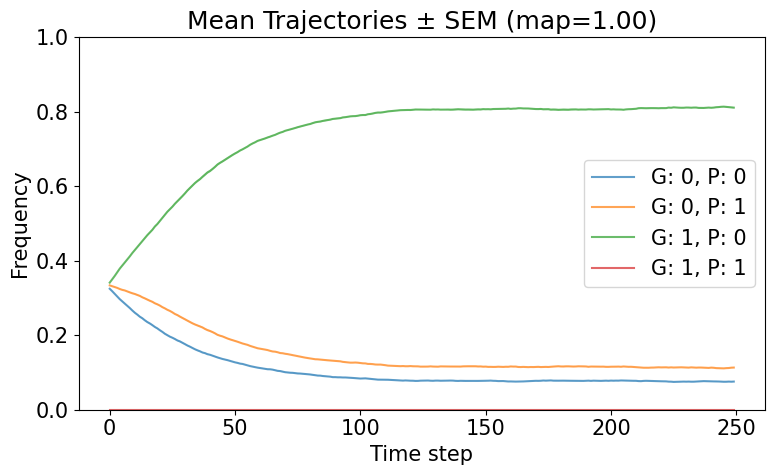

In [20]:
# Regex to extract map and trial
pattern = re.compile(r"sim_data_map_([0-9]+\.[0-9]+)_trial_([0-9]+)\.pkl")

# -----------------------------
# Build file dictionary: {map_val: {trial: filepath}}
# -----------------------------
files = [f for f in os.listdir(data_dir) if f.endswith(".pkl")]
file_dict = {}
for fname in files:
    match = pattern.match(fname)
    if match:
        map_val = float(match.group(1))
        trial = int(match.group(2))
        file_dict.setdefault(map_val, {})[trial] = os.path.join(data_dir, fname)

map_values = sorted(file_dict.keys())

# -----------------------------
# Plot mean ± SEM trajectories for each map
# -----------------------------
for map_val in map_values:
    trajs = []

    # Load trials
    for trial, fpath in sorted(file_dict[map_val].items()):
        with open(fpath, "rb") as fh:
            data = pickle.load(fh)
        freq_timeseries = np.array(data["freq_timeseries"])  # shape (2,2,timesteps)
        trajs.append(freq_timeseries)

    trajs = np.stack(trajs, axis=0)  # (n_trials, 2, 2, timesteps)
    n_trials = trajs.shape[0]

    # Compute mean and SEM across trials
    mean_traj = trajs.mean(axis=0)       # (2, 2, timesteps)
    sem_traj = trajs.std(axis=0) / np.sqrt(n_trials)  # (2, 2, timesteps)

    timesteps = np.arange(mean_traj.shape[2])
    plt.figure(figsize=(8,5))

    # Plot each (g,p) pair
    for i in range(2):
        for j in range(2):
            y = mean_traj[i, j, :]
            yerr = sem_traj[i, j, :]
            plt.plot(timesteps, y, label=f'G: {i}, P: {j}', alpha=0.7)
            plt.fill_between(timesteps, y - yerr, y + yerr, alpha=0.2)

    plt.title(f"Mean Trajectories ± SEM (map={map_val:.2f})")
    plt.xlabel("Time step")
    plt.ylabel("Frequency")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
# # show the genotype graph 

# G = nx.from_numpy_array(data['A'])
# node_labels = {i: f'{i}' for i in range(len(data['A']))}

# plt.figure(figsize=(5, 3))
# pos = nx.spring_layout(G) 
# nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
# plt.title('Genotype graph (G)')
# plt.show()

In [17]:
# # show the genotype-phenotype graph 

# G = nx.from_numpy_array(data['A'])
# node_labels = {i: f'({i}, 0)' for i in range(len(data['A']))}

# new_nodes = []
# new_edges = []

# # add phenotype nodes dynamically to each genotype node in the graph
# new_node_start_index = len(G.nodes)

# for node in G.nodes:
#     for i in range(Q-1):  
#         new_node = new_node_start_index + node * (Q-1) + i
#         new_nodes.append(new_node)  # collect new node
#         new_edges.append((node, new_node))  # collect edge between parent and child

# G.add_nodes_from(new_nodes)  
# G.add_edges_from(new_edges)  

# # labels for phenotype nodes
# for child_node in new_nodes:
#     genotype_parent = child_node % len(new_nodes)
#     child_number = child_node % (Q-1) + 1
#     node_labels[child_node] = '(' + str(genotype_parent) + ', ' + str(child_number) + ')'

# # colors 
# node_colors = []
# for node in G.nodes:
#     if node < len(data['A']):  
#         node_colors.append('skyblue')
#     else:  
#         node_colors.append('lightgreen')

# # positioning the nodes
# pos = nx.spring_layout(G, seed=42)

# # offset the children below their parent nodes
# child_pos_offset = 0.50 
# for node in range(len(data['A'])):
#     children = [n for n in G.neighbors(node)]  
#     child_count = 0
#     for child in children:
#         if child >= len(data['A']): 
#             pos[child] = (pos[node][0], pos[node][1] - child_pos_offset * (child_count + 1))
#             child_count += 1

# plt.figure(figsize=(5, 3))
# nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color=node_colors, font_size=12, font_weight='bold', edge_color='gray')

# plt.title("Genotype-phenotype graph (G, P)")
# plt.show()

In [19]:
# plt.figure(figsize=(8, 4))

# # loop through each (genotype, phenotype) pair
# for i in range(V):  # genotypes 
#     for j in range(Q):  # phenotypes 
#         plt.plot(data['freq_timeseries'][i, j, :], label=f'G: {i}, P: {j}', alpha=0.7)

# plt.xlabel('Time')
# plt.ylabel('Frequency')
# plt.ylim(-0.01,1.01)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

In [18]:
# import scipy.stats


# time_average = np.mean(data['freq_timeseries'], axis=2).flatten()
# theory = data['f_eq']

# plt.plot(time_average, theory, 'o')

# # compute Pearson correlation
# correlation, _ = scipy.stats.pearsonr(time_average, theory)

# # plot the line
# x = np.linspace(0, 1, 100)
# y = x
# plt.plot(x, y, color='red', linestyle='--', label=f'Pearson r: {correlation:.2f}')
# # ax.set_yscale('log')
# # ax.set_xscale('log')
# # ax.axvline(1/1000, color='gray', linestyle='--')
# # ax.axvline(1/np.sqrt(1000), color='green', linestyle='--')
# plt.xlabel('Simulation time-averaged frequency')
# plt.ylabel('Theoretical predicted frequency')
# plt.ylim(-0.01, 1.01)
# # plt.text(0.05, 0.9, f'Pearson r: {correlation:.2f}')
# plt.legend()
# plt.tight_layout()
# plt.show()